# 🏃‍♀️ Triathlon Data Science: Predicting Fitness Fatigue & Overtraining Risk

Welcome to my personal data science project where I explore my own Garmin activity data to identify potential signs of overtraining or fatigue. This notebook serves as the first step: Exploratory Data Analysis (EDA).

## 🎯 Goal

The goal of this project is to use wearable fitness data (heart rate, activity type, training load) to find patterns that may signal overtraining or upcoming burnout. The longer-term goal is to build a lightweight model that flags risky training periods based on this data.


## 📥 Load and Preview Data

In [78]:
import pandas as pd
df = pd.read_csv('Activities.csv')
df.head()

,Activiteittype,Datum,Favoriet,Titel,Afstand,Calorieën,Tijd,Gem. HS,Max. HS,Training effect aeroob,...,Max ademh,Stresswijziging,Stress vooraf,Stress achteraf,Gemiddelde stress,Max stress,Tijd bewogen,Verstreken tijd,Minimum hoogte,Maximum hoogte
0,Hardlopen,2025-05-19 09:50:28,False,Amsterdam Hardlopen,5.48,281,00:28:01,151,169,3.2,...,--,--,--,--,--,--,00:27:52,00:34:55,1,10
1,Hardlopen,2025-05-18 20:03:44,False,Amsterdam Hardlopen,5.25,280,00:30:28,141,151,3.0,...,--,--,--,--,--,--,00:30:24,00:30:28,-2,7
2,Wegwielrennen,2025-05-18 09:22:31,False,Renkum Wegwielrennen,120.19,"1,812",04:16:05,151,181,5.0,...,49,--,--,--,--,--,04:15:16,05:04:08,4,108
3,Hardlopen,2025-05-16 10:52:12,False,Amsterdam Hardlopen,8.83,457,00:47:10,145,167,3.8,...,--,--,--,--,--,--,00:46:55,00:56:41,-2,10
4,Wegwielrennen,2025-05-15 18:46:39,False,Diemen Wegwielrennen,64.34,944,02:21:15,149,180,5.0,...,44,--,--,--,--,--,02:20:50,02:27:12,-5,11


In [81]:
# Look at swimming activities whose distances are in meters not km.
df[df['Activiteittype'] == 'Zwemmen in open water'][['Datum','Afstand', 'Calorieën']]

,Datum,Afstand,Calorieën
143,2024-09-08 15:06:30,0.227,43
144,2024-09-08 08:48:28,0.391,69
146,2024-09-02 07:08:15,0.817,155
148,2024-08-31 14:42:52,0.677,154
149,2024-08-30 14:16:57,1.053,223
150,2024-08-30 10:17:24,1.436,343
164,2024-08-11 09:46:50,1.599,384
219,2024-06-21 12:58:48,0.359,57


## 🧼 Data Cleaning

In [80]:
# Step 1: Fix distance ONLY for swimming activities
# Remove comma in 'Afstand' (e.g., '1,725') → '1725', then convert to float
swim_mask = df['Activiteittype'].isin(['Zwembad', 'Zwemmen in open water'])

df.loc[swim_mask, 'Afstand'] = (
    df.loc[swim_mask, 'Afstand']
    .astype(str)
    .str.replace(',', '')        # Remove comma for numbers like '1,725'
    .astype(float) / 1000        # Convert meters to kilometers
)


In [82]:
df = df.rename(columns={
    'Activiteittype': 'Activity Type',
    'Datum': 'Date',
    'Afstand': 'Distance (km)',
    'Calorieën': 'Calories',
    'Tijd': 'Duration',
    'Gem. HS': 'Avg Heart Rate',
    'Max. HS': 'Max Heart Rate',
    'Training effect aeroob': 'Aerobic TE',
    'Totale stijging': 'Elevation Gain (m)',
    'Tijd bewogen': 'Moving Time',
    'Verstreken tijd': 'Elapsed Time',
    'Minimum hoogte': 'Min Altitude',
    'Maximum hoogte': 'Max Altitude'
})

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Distance (km)'] = pd.to_numeric(df['Distance (km)'], errors='coerce')
df['Calories'] = pd.to_numeric(df['Calories'].astype(str).str.replace(',', ''), errors='coerce')
df['Avg Heart Rate'] = pd.to_numeric(df['Avg Heart Rate'], errors='coerce')
df['Max Heart Rate'] = pd.to_numeric(df['Max Heart Rate'], errors='coerce')
df['Aerobic TE'] = pd.to_numeric(df['Aerobic TE'], errors='coerce')
df = df.dropna(subset=['Date'])
df.head()

,Activity Type,Date,Favoriet,Titel,Distance (km),Calories,Duration,Avg Heart Rate,Max Heart Rate,Aerobic TE,...,Max ademh,Stresswijziging,Stress vooraf,Stress achteraf,Gemiddelde stress,Max stress,Moving Time,Elapsed Time,Min Altitude,Max Altitude
0,Hardlopen,2025-05-19 09:50:28,False,Amsterdam Hardlopen,5.48,281,00:28:01,151.0,169.0,3.2,...,--,--,--,--,--,--,00:27:52,00:34:55,1,10
1,Hardlopen,2025-05-18 20:03:44,False,Amsterdam Hardlopen,5.25,280,00:30:28,141.0,151.0,3.0,...,--,--,--,--,--,--,00:30:24,00:30:28,-2,7
2,Wegwielrennen,2025-05-18 09:22:31,False,Renkum Wegwielrennen,120.19,1812,04:16:05,151.0,181.0,5.0,...,49,--,--,--,--,--,04:15:16,05:04:08,4,108
3,Hardlopen,2025-05-16 10:52:12,False,Amsterdam Hardlopen,8.83,457,00:47:10,145.0,167.0,3.8,...,--,--,--,--,--,--,00:46:55,00:56:41,-2,10
4,Wegwielrennen,2025-05-15 18:46:39,False,Diemen Wegwielrennen,64.34,944,02:21:15,149.0,180.0,5.0,...,44,--,--,--,--,--,02:20:50,02:27:12,-5,11


In [85]:
# Define which activities to keep and how to rename them
activity_map = {
    'Hardlopen': 'Running',
    'Wegwielrennen': 'Cycling',
    'Virtueel fietsen': 'Cycling',
    'Zwembad': 'Swimming',
    'Zwemmen in open water': 'Swimming'
}

# Filter only the activities we want
df = df[df['Activity Type'].isin(activity_map.keys())]

# Apply mapping to unify activity names
df['Activity Category'] = df['Activity Type'].map(activity_map)
df.head()

/var/folders/qy/1th4gkcx0vlb__rw8vzpddlh0000gn/T/ipykernel_6473/3878494461.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Activity Type,Date,Favoriet,Titel,Distance (km),Calories,Duration,Avg Heart Rate,Max Heart Rate,Aerobic TE,...,Stresswijziging,Stress vooraf,Stress achteraf,Gemiddelde stress,Max stress,Moving Time,Elapsed Time,Min Altitude,Max Altitude,Activity Category
0,Hardlopen,2025-05-19 09:50:28,False,Amsterdam Hardlopen,5.48,281,00:28:01,151.0,169.0,3.2,...,--,--,--,--,--,00:27:52,00:34:55,1,10,Running
1,Hardlopen,2025-05-18 20:03:44,False,Amsterdam Hardlopen,5.25,280,00:30:28,141.0,151.0,3.0,...,--,--,--,--,--,00:30:24,00:30:28,-2,7,Running
2,Wegwielrennen,2025-05-18 09:22:31,False,Renkum Wegwielrennen,120.19,1812,04:16:05,151.0,181.0,5.0,...,--,--,--,--,--,04:15:16,05:04:08,4,108,Cycling
3,Hardlopen,2025-05-16 10:52:12,False,Amsterdam Hardlopen,8.83,457,00:47:10,145.0,167.0,3.8,...,--,--,--,--,--,00:46:55,00:56:41,-2,10,Running
4,Wegwielrennen,2025-05-15 18:46:39,False,Diemen Wegwielrennen,64.34,944,02:21:15,149.0,180.0,5.0,...,--,--,--,--,--,02:20:50,02:27:12,-5,11,Cycling


In [87]:
print("📅 Data Summary")
print("----------------------------")
print(f"Start date: {df['Date'].min().date()}")
print(f"End date:   {df['Date'].max().date()}")
print(f"Total activities: {df.shape[0]}")
print("Activity type counts:")
print(df['Activity Category'].value_counts())

📅 Data Summary
----------------------------
Start date: 2024-06-21
End date:   2025-05-19
Total activities: 183
Activity type counts:
Running     86
Swimming    55
Cycling     42
Name: Activity Category, dtype: int64


## 📊 Exploratory Data Analysis

In [89]:
import plotly.express as px

# Interactive countplot of activity types
fig = px.histogram(df, x='Activity Type', color='Activity Type',
                   title='Activity Distribution',
                   category_orders={'Activity Type': df['Activity Type'].value_counts().index})
fig.update_layout(bargap=0.2, xaxis_title='Activity Type', yaxis_title='Count')
fig.show()

In [18]:
import plotly.express as px
fig = px.histogram(df, x='Activity Category', color='Activity Category',
                   title='Activity Distribution (Grouped)',
                   category_orders={'Activity Category': df['Activity Category'].value_counts().index})
fig.update_layout(bargap=0.2, xaxis_title='Activity', yaxis_title='Count')
fig.show()

### 📈 1. Heart Rate Trends

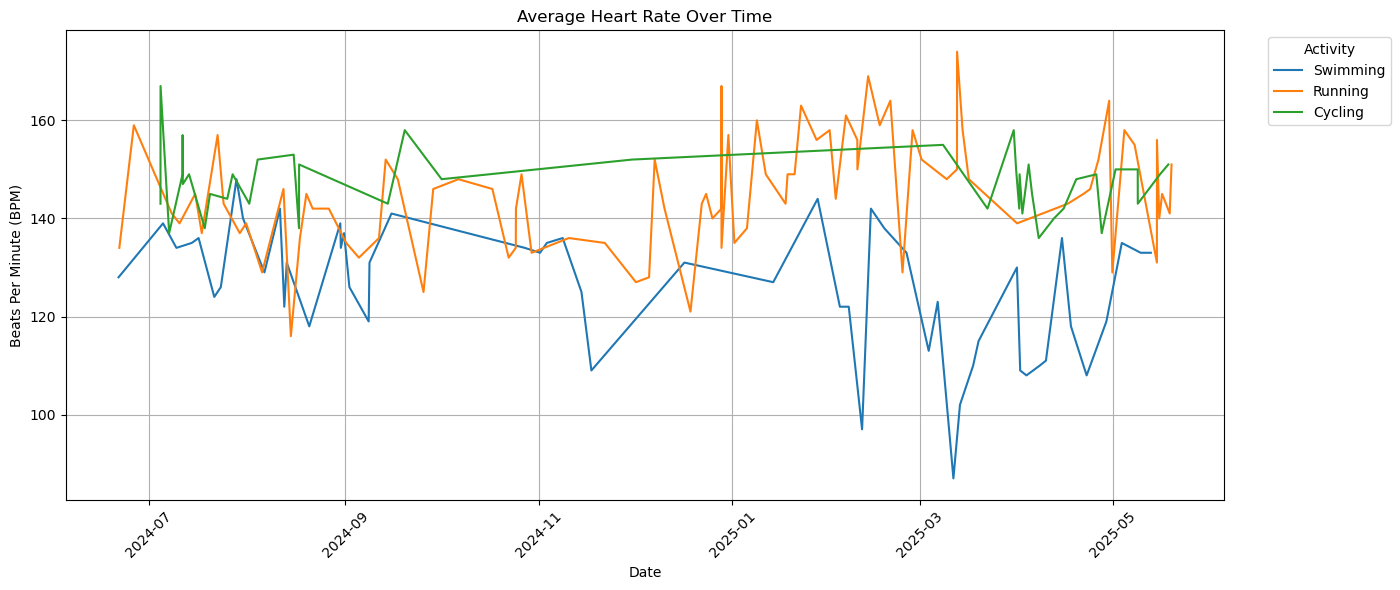

In [90]:
plt.figure(figsize=(14,6))
sns.lineplot(data=df.sort_values('Date'), x='Date', y='Avg Heart Rate', hue='Activity Category')
plt.title('Average Heart Rate Over Time')
plt.ylabel('Beats Per Minute (BPM)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend(title='Activity', loc='upper right', bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.grid(True)
plt.show()

### 📊 2. Weekly Summary by Category

In [98]:
df['Week'] = df['Date'].dt.to_period('W').apply(lambda r: r.start_time)

weekly_summary = df.groupby(['Week', 'Activity Category']).agg({
    'Distance (km)': 'sum',
    'Calories': 'sum',
    'Avg Heart Rate': 'mean',
    'Aerobic TE': 'mean'
}).reset_index()

# Example: plot weekly distance per category
fig = px.line(weekly_summary, x='Week', y='Distance (km)', color='Activity Category',
              title='Weekly Distance per Sport')
fig.update_layout(xaxis_title='Week', yaxis_title='Distance (km)', legend_title='Activity')
fig.show()

/var/folders/qy/1th4gkcx0vlb__rw8vzpddlh0000gn/T/ipykernel_6473/4229586498.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### 📍 Case Observation: Mallorca Triathlon Camp (Week of March 31, 2025)

In the week starting **March 31, 2025**, I attended a triathlon training camp in Mallorca. This week included intensive daily cycling sessions across various terrains. 

As shown in the graph, there is a significant spike in cycling distance, totaling approximately **412 kilometers** — a sharp peak that stands out clearly in comparison to the surrounding weeks.

This kind of sudden load increase is a great example of how specific training blocks (like camps) can impact training data, and why identifying these patterns is important when analyzing training stress and potential overtraining risks.

In [99]:
df.head()

,Activity Type,Date,Favoriet,Titel,Distance (km),Calories,Duration,Avg Heart Rate,Max Heart Rate,Aerobic TE,...,Stress vooraf,Stress achteraf,Gemiddelde stress,Max stress,Moving Time,Elapsed Time,Min Altitude,Max Altitude,Activity Category,Week
0,Hardlopen,2025-05-19 09:50:28,False,Amsterdam Hardlopen,5.48,281,00:28:01,151.0,169.0,3.2,...,--,--,--,--,00:27:52,00:34:55,1,10,Running,2025-05-19
1,Hardlopen,2025-05-18 20:03:44,False,Amsterdam Hardlopen,5.25,280,00:30:28,141.0,151.0,3.0,...,--,--,--,--,00:30:24,00:30:28,-2,7,Running,2025-05-12
2,Wegwielrennen,2025-05-18 09:22:31,False,Renkum Wegwielrennen,120.19,1812,04:16:05,151.0,181.0,5.0,...,--,--,--,--,04:15:16,05:04:08,4,108,Cycling,2025-05-12
3,Hardlopen,2025-05-16 10:52:12,False,Amsterdam Hardlopen,8.83,457,00:47:10,145.0,167.0,3.8,...,--,--,--,--,00:46:55,00:56:41,-2,10,Running,2025-05-12
4,Wegwielrennen,2025-05-15 18:46:39,False,Diemen Wegwielrennen,64.34,944,02:21:15,149.0,180.0,5.0,...,--,--,--,--,02:20:50,02:27:12,-5,11,Cycling,2025-05-12


### 📦 3. Feature Engineering for Modeling

We’ll aggregate key training indicators by week and activity type to observe trends and prepare for modeling:
- Weekly distance per sport
- Average heart rate
- Aerobic training effect

In [110]:
# Pivot to make each activity type a column
weekly_pivot = weekly_summary.pivot(index='Week', columns='Activity Category', values='Distance (km)').fillna(0)
weekly_pivot.columns.name = None
weekly_pivot.reset_index(inplace=True)

# Preview result
weekly_pivot.head()

,Week,Cycling,Running,Swimming
0,2024-06-17,0.00,2.47,0.359
1,2024-06-24,0.00,4.05,0.000
2,2024-07-01,77.14,0.00,1.700
3,2024-07-08,94.28,7.66,2.600
4,2024-07-15,144.36,10.23,3.950


In [111]:
# Sort by week
weekly_pivot = weekly_pivot.sort_values('Week')

# Focus on total training load (you can also do per sport separately)
weekly_pivot['Total Distance (km)'] = weekly_pivot[['Running', 'Cycling', 'Swimming']].sum(axis=1)

# Calculate rolling training load metrics
weekly_pivot['Load_3w'] = weekly_pivot['Total Distance (km)'].rolling(window=3, min_periods=1).sum()
weekly_pivot['Load_7w'] = weekly_pivot['Total Distance (km)'].rolling(window=7, min_periods=1).mean()

# Calculate Acute:Chronic Workload Ratio (ACWR)
weekly_pivot['ACWR'] = weekly_pivot['Load_3w'] / weekly_pivot['Load_7w']

# Optional: Create a basic risk label
weekly_pivot['Risk_Flag'] = weekly_pivot['ACWR'].apply(lambda x: 1 if x > 1.5 else 0)

# View result
weekly_pivot[['Week', 'Total Distance (km)', 'Load_3w', 'Load_7w', 'ACWR', 'Risk_Flag']].tail()

,Week,Total Distance (km),Load_3w,Load_7w,ACWR,Risk_Flag
43,2025-04-21,181.980,472.510,146.382143,3.227921,1
44,2025-04-28,135.355,498.010,161.190000,3.089584,1
45,2025-05-05,71.250,388.585,162.767857,2.387357,1
46,2025-05-12,210.505,417.110,186.885714,2.231899,1
47,2025-05-19,5.480,287.235,127.871429,2.246280,1


Load_3w: sum of distance over last 3 weeks = "acute load"

Load_7w: average load over last 7 weeks = "fitness"

ACWR: if >1.5 → possible overload (body not ready for the spike)

Risk_Flag: 1 = risky week, 0 = stable

In [113]:
weekly_pivot.sort_values(by='Week', ascending=False)

,Week,Cycling,Running,Swimming,Total Distance (km),Load_3w,Load_7w,ACWR,Risk_Flag
47,2025-05-19,0.00,5.48,0.000,5.480,287.235,127.871429,2.246280,1
46,2025-05-12,184.53,24.25,1.725,210.505,417.110,186.885714,2.231899,1
45,2025-05-05,62.19,7.41,1.650,71.250,388.585,162.767857,2.387357,1
44,2025-04-28,94.95,34.78,5.625,135.355,498.010,161.190000,3.089584,1
43,2025-04-21,156.87,23.11,2.000,181.980,472.510,146.382143,3.227921,1
42,2025-04-14,174.48,2.62,3.575,180.675,709.110,135.462857,5.234719,1
41,2025-04-07,106.98,0.00,2.875,109.855,570.115,113.113571,5.040200,1
40,2025-03-31,412.74,2.54,3.300,418.580,520.465,99.209286,5.246132,1
39,2025-03-24,41.68,0.00,0.000,41.680,133.585,43.409286,3.077337,1
38,2025-03-17,57.73,0.00,2.475,60.205,197.450,41.049286,4.810072,1


### 📊 ACWR Visualization

The Acute:Chronic Workload Ratio (ACWR) helps detect sudden increases in training load that the body may not be ready for. 

- A value above **1.5** is commonly seen as a threshold for elevated risk of overtraining or injury.
- In the plot below, **red points** highlight weeks where the ACWR exceeds this threshold.

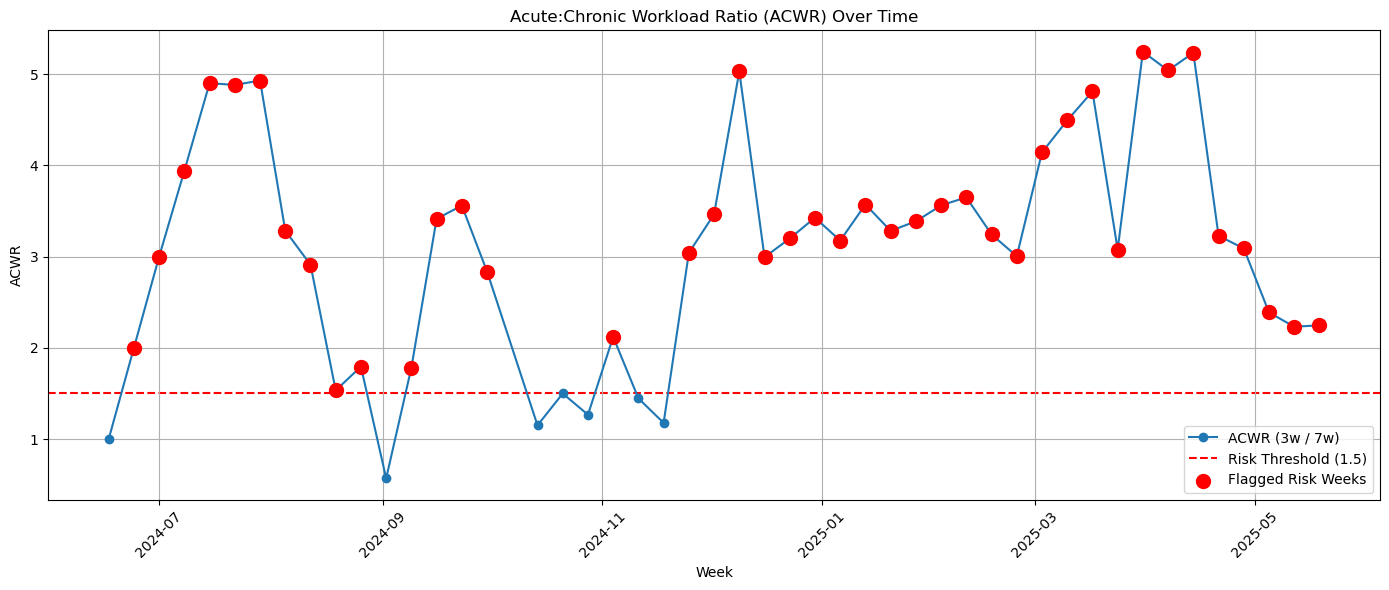

In [123]:
plt.figure(figsize=(14,6))

# Line plot
plt.plot(weekly_pivot['Week'], weekly_pivot['ACWR'], marker='o', label='ACWR (3w / 7w)', zorder=3)

# Risk line
plt.axhline(1.5, color='red', linestyle='--', label='Risk Threshold (1.5)', zorder=1)

# Risky weeks only
risky_weeks = weekly_pivot[weekly_pivot['Risk_Flag'] == 1]

# Add scatter dots above the line
plt.scatter(risky_weeks['Week'], risky_weeks['ACWR'], color='red', s=100, label='Flagged Risk Weeks', zorder=5)

# Labels and styling
plt.title('Acute:Chronic Workload Ratio (ACWR) Over Time')
plt.xlabel('Week')
plt.ylabel('ACWR')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()